In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from numpy import random
import pickle
import scipy.stats as st
import itertools 
import seaborn as sns

# Filters dataframe based on neuron type. 
# Establishes a synapse threshold of greater than 1
# data - the dataframe
# col_substr - regex to select for substrings that represent neuron type in columns
# row_substr - regex to select for substrings that represent neuron type in rows
# row_header - header for indices
def filter_neuron_types(data, col_substr, row_substr, idx_header):
    first_column = df.iloc[:, 0] # gets first column to use as row indices
    # columns
    new_df = data.filter(regex=col_substr, axis='columns') 
    
    # rows
    new_df.insert(0, idx_header, first_column, True) # inserts column with row labels into the new dataframe
    new_df.set_index(idx_header, inplace=True) # sets inserted column as dataframe indicies
    new_df = new_df.filter(regex=row_substr, axis='index')
    
    # establishing a threshold of num synapses > 1 to count as a connection
    num_rows = len(new_df)
    # loops thru rows of new_df
    for i in range(num_rows):
        row = new_df.iloc[i] # gets row
        new_row = np.where(row == 1, 0, row) # if synaspse num = 1, change to 0
        new_df.iloc[i] = new_row
    
    return new_df

# Normalizes weights by column's sum in a pandas df
# df - dataframe
# sum_of_w - the sum of the weights
def normalize_weights_df(df, sum_of_w):
    col = len(df.columns)
    #df.iloc[:,0:col] = df.iloc[:,0:col].apply(lambda x: x / np.linalg.norm(x), axis=0)
    #df = normalize(df, axis=0, norm='l1') # normalize by column to sum of 1
    for c in range(col):
        w = df.iloc[:,c]
        s = sum(abs(w)) # sum of column
        if (s != 0):
            df.iloc[:,c] = [i/s for i in w]
    return sum_of_w * df

# Normalizes weights by column's sum in a numpy array
# arr - numpy array
# sum_of_w - the sum of the weights
def normalize_weights_np(arr, sum_of_w):
    col = len(arr[0])
    #df.iloc[:,0:col] = df.iloc[:,0:col].apply(lambda x: x / np.linalg.norm(x), axis=0)
    #df = normalize(df, axis=0, norm='l1') # normalize by column to sum of 1
    for c in range(col):
        w = arr[:,c]
        s = sum(abs(w)) # sum of column
        if (s != 0):
            arr[:,c] = [i/s for i in w]
    return sum_of_w * arr

# get the number kc from string arr
# a - num kcs removed
def get_num_kc(string, a):
    nums = np.zeros(a)
    for i in range(a):
        end = False
        s = string[i]
        j = 1
        num_str = ""
        while end == False:
            # end loop if space is reached
            if s[-j] == " ": 
                end = True
            else:
                num_str = s[-j] + num_str
            j += 1
        nums[i] = int(num_str)
    return nums

# mbon - index of mbon
def count_num_removed(kc_mbon, nums, mbon):
    count = 0
    nums = nums.astype(int)
    for i in range(len(nums)):
        if kc_mbon.iloc[nums[i], mbon] != 0:
            count += 1
    return count


df = pd.read_csv('connectivity matrix table 1.csv') # matrix of connections between neurons

# FILTER DATA FOR PNs (rows) to KCs (columns) CONNECTIONS -> pn_kc
pn_kc = filter_neuron_types(df, "(?=.*KC)(?=.*left)", "(?=.*PN)(?=.*left)", "Presynaptic PNs") # filter w/ regex PNs and KCs

# normalize weights
pn_kc = normalize_weights_df(pn_kc, 1)

# FILTER DATA FOR KCs TO MBONs CONNECTIONS -> kc_to_mbon
kc_mbon = filter_neuron_types(df, "(?=.*MBON)(?=.*left)", "(?=.*KC)(?=.*left)", "Presynaptic KCs") # filter w/ regex for KCs and MBON lefts

# take out MBONs with no KC connections
kc_mbon = kc_mbon.drop(kc_mbon.loc[:, (kc_mbon.sum(axis=0) == 0)], axis=1)

# adding a fictional MBON
fict_weights = np.full(len(kc_mbon), 0.1) # initializing all weights at 0.1
kc_mbon['MBON-fict'] = fict_weights

# normalizing weights
kc_mbon = normalize_weights_df(kc_mbon, 1)
kc_mbon = kc_mbon.fillna(0)

# Set numbers
num_kcs = len(pn_kc.columns)
num_pns = len(pn_kc) # number of PNs (40), also = number of dimensions of the odor
num_mbons = len(kc_mbon.columns)
R = 10 # number of realizations of training
K = 23 # number of KC removal sets

# color palette (19 colors)
colors = ['steelblue', 'darkorange', 'forestgreen', 'crimson', 'mediumpurple', 'rosybrown', 
          'pink', 'goldenrod', 'darkturquoise', 'thistle', 'lightsteelblue', 'peachpuff', 
          'lightgreen', 'lightsalmon', 'sienna', 'orchid', 'gray', 'khaki', 'lightblue']

In [20]:
bool_syn = np.where(kc_mbon > 0, 1, 0)
sums = np.sum(bool_syn, axis=0)
for m in range(num_mbons):
    print(f"{kc_mbon.columns[m]}: {sums[m]}")
    
print(f"Average: {np.mean(sums[:-1])}")

MBON-a1 left: 55
MBON-a2 left: 63
MBON-b1 left: 46
MBON-b2 left: 47
MBON-c1 left: 54
MBON-d1 left: 53
MBON-e1 left: 59
MBON-e2 left: 38
MBON-g1 left: 61
MBON-g2 left: 61
MBON-h1 left: 54
MBON-h2 left: 53
MBON-i1 left: 42
MBON-k1 left: 30
MBON-m1 left: 51
MBON-n1 left: 3
MBON-o1 left: 17
MBON-q1 left: 36
MBON-fict: 110
Average: 45.72222222222222


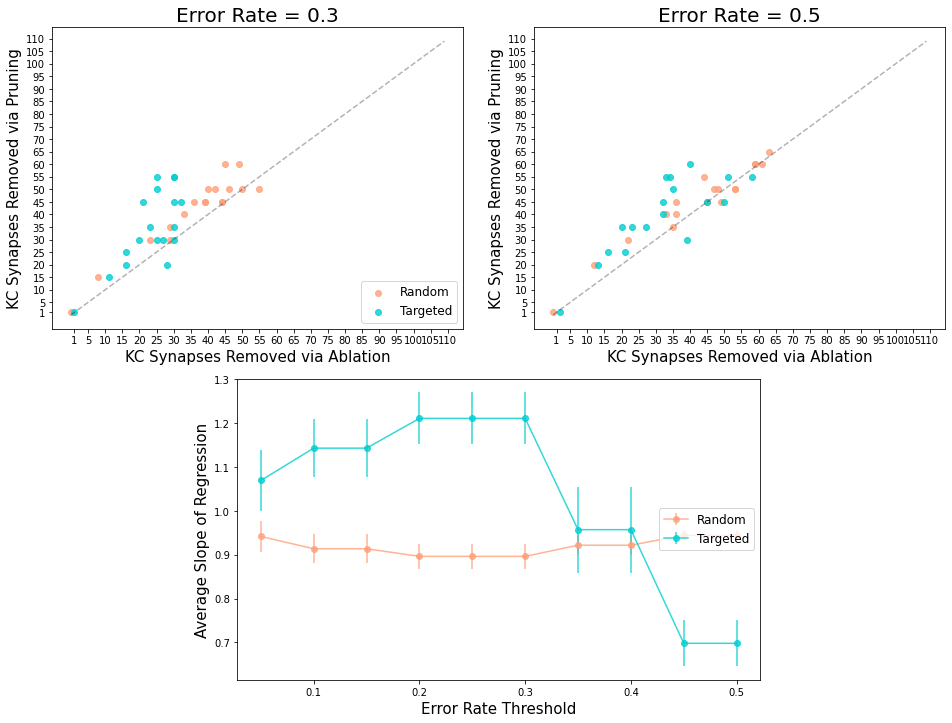

In [11]:
axis_fontsize = 15
title_fontsize = 20
legend_fontsize = 12
fig7 = plt.figure(figsize=(16,12), constrained_layout=False)
gs7 = fig7.add_gridspec(ncols=6, nrows=4)

gs7.update(wspace=0.8, hspace=0.4) # set the spacing between axes

# NUMBER PRUNED VS ABLATED 
# 7A ER THRESHOLD = 0.3
f7_ax1 = fig7.add_subplot(gs7[0:2, 0:3])

# 7B ER THRESHOLD = 0.5
f7_ax2 = fig7.add_subplot(gs7[0:2, 3:6])

# excluding the fictional MBON, there are 18 MBONs
num_mbons = 18

# RANDOM
# import data 
with open('C:/Katherine/Research/experiment-data-v3/10-odors/control2/all-error-rates7.pkl', 'rb') as f:
    error_control_p = pickle.load(f) # dimensions: R, T, num_mbons
error_control_a = error_control_p
with open('C:/Katherine/Research/experiment-data-v3/10-odors/random-pruning/all-error-rates12.pkl', 'rb') as f:
    error_over_time_p = pickle.load(f) # dimensions: K, R, T, num_mbons
    
with open('C:/Katherine/Research/experiment-data-v3/10-odors/random-ablation/all-error-rates14.pkl', 'rb') as f:
    error_over_time_a = pickle.load(f) # dimensions: K, R, T, num_mbons
    
with open('C:/Katherine/Research/experiment-data-v3/10-odors/random-ablation/kcs-removed14.pkl', 'rb') as f:
    kcs_removed = pickle.load(f)

# number of KCs supposedly to be removed
numbers = np.ones(23)
numbers[1:] = np.linspace(5, 110, 22)
numbers = numbers.astype(int).tolist()

# PRUNING
# x_p - number of KC synapses removed 
x_p = []

for i in range(num_mbons):
    for j in range(K):
        x_p.append(numbers[j])

# y_p - final error rate for realization r
y_p = []
for k in range(num_mbons):
    for i in range(K):
        y_p.append(error_over_time_p[i,0,-1,k]) # exclude fictional MBON (will skew results)

# ABLATION
# gets number of presynaptic KCs for each MBON
bool_synapses = np.where(kc_mbon > 0, 1, 0)
conn = np.zeros(num_mbons)
for j in range(num_mbons):
    conn[j] = bool_synapses[:,j].sum()
conn = conn.astype(int) # number of connections to each MBON

# number of KCs removed
x_a = []

# x_a - calculates the actual number of synapses removed after ablation
for i in range(num_mbons):
    for j in range(K):
        n = numbers[j] # num kcs ablated
        l = kcs_removed[j][0] # list of kcs removed for realization 1
        l_num = get_num_kc(l, n) # converts list of names to numbers

        num_removed = count_num_removed(kc_mbon, l_num, i) # number of kc connections removed from this MBON
        x_a.append(num_removed)    

# y_a - final error rate for realization r
y_a = []
for m in range(num_mbons):
    for k in range(K):
        y_a.append(error_over_time_a[k, 0, -1, m]) # excludes fict. MBON (skews results)

# SUMMARY (ER = 0.3)
# pruning
x_p = np.asarray(x_p).reshape(num_mbons, K)
y_p = np.asarray(y_p).reshape(num_mbons, K)

# ablation
x_a = np.asarray(x_a).reshape(num_mbons, K)
y_a = np.asarray(y_a).reshape(num_mbons, K)

# Get the x and y coordinates for summary plot
x = np.zeros(num_mbons) # ablation
y = np.zeros(num_mbons) # pruning

for m in range(num_mbons):
    num_removed_x = 0
    # ablation
    found_a = False
    k_a = 0 # move through the columns
    while (not found_a) and (k_a < K):
        if y_a[m, k_a] >= 0.3:
            x[m] = x_a[m, k_a]
            found_a = True
        k_a += 1

    # pruning
    found_p = False
    k_p = 0 # move through the columns
    while (not found_p) and (k_p < K):
        # ablation
        if y_p[m, k_p] >= 0.3:
            y[m] = x_p[m, k_p]
            found_p = True
        k_p += 1 

# MBON names
names = kc_mbon.columns[0:-1]

# plot for ER = 0.3
f7_ax1.scatter(x, y, alpha=0.8, c=colors[13], label="Random")

# SUMMARY (ER = 0.5)
# pruning
x_p = np.asarray(x_p).reshape(num_mbons, K)
y_p = np.asarray(y_p).reshape(num_mbons, K)

# ablation
x_a = np.asarray(x_a).reshape(num_mbons, K)
y_a = np.asarray(y_a).reshape(num_mbons, K)

# Get the x and y coordinates for summary plot
x = np.zeros(num_mbons) # ablation
y = np.zeros(num_mbons) # pruning

for m in range(num_mbons):
    num_removed_x = 0
    # ablation
    found_a = False
    k_a = 0 # move through the columns
    while (not found_a) and (k_a < K):
        if y_a[m, k_a] >= 0.5:
            x[m] = x_a[m, k_a]
            found_a = True
        k_a += 1

    # pruning
    found_p = False
    k_p = 0 # move through the columns
    while (not found_p) and (k_p < K):
        # ablation
        if y_p[m, k_p] >= 0.5:
            y[m] = x_p[m, k_p]
            found_p = True
        k_p += 1 

# MBON names
names = kc_mbon.columns[0:-1]

# plot for ER = 0.5
f7_ax2.scatter(x, y, alpha=0.8, c=colors[13], label="Random")

# TARGETED
# import data 
with open('C:/Katherine/Research/experiment-data-v3/10-odors-left/control2/all-error-rates7.pkl', 'rb') as f:
    error_control_p = pickle.load(f) # dimensions: R, T, num_mbons
    
with open('C:/Katherine/Research/experiment-data-v3/10-odors-left/targeted-pruning/all-error-rates13.pkl', 'rb') as f:
    error_over_time_p = pickle.load(f) # dimensions: K, R, T, num_mbons
    
with open('C:/Katherine/Research/experiment-data-v3/10-odors-left/control2/all-error-rates7.pkl', 'rb') as f:
    error_control_a = pickle.load(f) # dimensions: R, T, num_mbons
    
with open('C:/Katherine/Research/experiment-data-v3/10-odors-left/targeted-ablation/all-error-rates10.pkl', 'rb') as f:
    error_over_time_a = pickle.load(f) # dimensions: K, R, T, num_mbons
    
with open('C:/Katherine/Research/experiment-data-v3/10-odors-left/targeted-ablation/kcs-removed10.pkl', 'rb') as f:
    kcs_removed = pickle.load(f)

# number of KCs supposedly to be removed
numbers = np.ones(23)
numbers[1:] = np.linspace(5, 110, 22)
numbers = numbers.astype(int).tolist()

# PRUNING
# x_p - number of KC synapses removed 
x_p = []

for i in range(num_mbons):
    for j in range(K):
        x_p.append(numbers[j])

# y_p - final error rate for realization r
y_p = []
for k in range(num_mbons):
    for i in range(K):
        y_p.append(error_over_time_p[i,0,-1,k]) # exclude fictional MBON (will skew results)


# ABLATION
# gets number of presynaptic KCs for each MBON
bool_synapses = np.where(kc_mbon > 0, 1, 0)
conn = np.zeros(num_mbons)
for j in range(num_mbons):
    conn[j] = bool_synapses[:,j].sum()
conn = conn.astype(int)

# number of KCs removed
x_a = []

# x_a - calculates the actual number of synapses removed
for i in range(num_mbons):
    for j in range(K):
        n = numbers[j] # num kcs ablated
        l = kcs_removed[j][0] # list of kcs removed for realization 1
        l_num = get_num_kc(l, n) # converts list of names to numbers

        num_removed = count_num_removed(kc_mbon, l_num, i) # number of kc connections removed from this MBON
        x_a.append(num_removed)    

#  y_a - final error rate for realization r
y_a = []
for m in range(num_mbons):
    for k in range(K):
        y_a.append(error_over_time_a[k, 0, -1, m]) # excludes fict. MBON (skews results)

# SUMMARY (ER = 0.3)
x_p = np.asarray(x_p).reshape(num_mbons, K)
y_p = np.asarray(y_p).reshape(num_mbons, K)

x_a = np.asarray(x_a).reshape(num_mbons, K)
y_a = np.asarray(y_a).reshape(num_mbons, K)

# Get the x and y coordinates for summary plot
x = np.zeros(num_mbons) # ablation
y = np.zeros(num_mbons) # pruning

for m in range(num_mbons):
    num_removed_x = 0
    # ablation
    found_a = False
    k_a = 0 # move through the columns
    while (not found_a) and (k_a < K):
        if y_a[m, k_a] >= 0.3:
            x[m] = x_a[m, k_a]
            found_a = True
        k_a += 1

    # pruning
    found_p = False
    k_p = 0 # move through the columns
    while (not found_p) and (k_p < K):
        # ablation
        if y_p[m, k_p] >= 0.3:
            y[m] = x_p[m, k_p]
            found_p = True
        k_p += 1 

# MBON names
names = kc_mbon.columns[0:-1]

# plot for ER = 0.3
f7_ax1.scatter(x, y, alpha=0.8, c=colors[8], label="Targeted")
f7_ax1.plot(np.arange(110), np.arange(110), alpha=0.3, linestyle='dashed', color='black') # plot line y = x
f7_ax1.set_xlabel("KC Synapses Removed via Ablation", fontsize=axis_fontsize)
f7_ax1.set_ylabel("KC Synapses Removed via Pruning", fontsize=axis_fontsize)
f7_ax1.set_xticks(numbers)
f7_ax1.set_yticks(numbers)
f7_ax1.set_title("Error Rate = 0.3", fontsize=title_fontsize)
f7_ax1.legend(fontsize=legend_fontsize, loc=4)

# SUMMARY (ER = 0.5)
# pruning
x_p = np.asarray(x_p).reshape(num_mbons, K)
y_p = np.asarray(y_p).reshape(num_mbons, K)

# ablation
x_a = np.asarray(x_a).reshape(num_mbons, K)
y_a = np.asarray(y_a).reshape(num_mbons, K)

# Get the x and y coordinates for summary plot
x = np.zeros(num_mbons) # ablation
y = np.zeros(num_mbons) # pruning

for m in range(num_mbons):
    num_removed_x = 0
    # ablation
    found_a = False
    k_a = 0 # move through the columns
    while (not found_a) and (k_a < K):
        if y_a[m, k_a] >= 0.5:
            x[m] = x_a[m, k_a]
            found_a = True
        k_a += 1

    # pruning
    found_p = False
    k_p = 0 # move through the columns
    while (not found_p) and (k_p < K):
        # ablation
        if y_p[m, k_p] >= 0.5:
            y[m] = x_p[m, k_p]
            found_p = True
        k_p += 1 

# MBON names
names = kc_mbon.columns[0:-1]

# plot for ER = 0.5
f7_ax2.scatter(x, y, alpha=0.8, c=colors[8], label="Targeted")
f7_ax2.plot(np.arange(110), np.arange(110), alpha=0.3, linestyle='dashed', color='black') # plot line y = x
f7_ax2.set_xlabel("KC Synapses Removed via Ablation", fontsize=axis_fontsize)
f7_ax2.set_ylabel("KC Synapses Removed via Pruning", fontsize=axis_fontsize)
f7_ax2.set_xticks(numbers)
f7_ax2.set_yticks(numbers)
f7_ax2.set_title("Error Rate = 0.5", fontsize=title_fontsize)

# 7C AVERAGE REGRESSION SLOPE VS ERROR RATE THRESHOLD
gs71 = gs7[2:4, :].subgridspec(1, 5)
f7_ax3 = fig7.add_subplot(gs71[0, 1:4])

# RANDOM
# import data
with open('C:/Katherine/Research/experiment-data-v3/10-odors-left/control2/all-error-rates7.pkl', 'rb') as f:
    error_control_p = pickle.load(f) # dimensions: R, T, num_mbons
error_control_a = error_control_p # dimensions: R, T, num_mbons
    
with open('C:/Katherine/Research/experiment-data-v3/10-odors-left/random-pruning/all-error-rates12.pkl', 'rb') as f:
    error_over_time_p = pickle.load(f) # dimensions: K, R, T, num_mbons
    
with open('C:/Katherine/Research/experiment-data-v3/10-odors-left/random-ablation/all-error-rates14.pkl', 'rb') as f:
    error_over_time_a = pickle.load(f) # dimensions: K, R, T, num_mbons
    
with open('C:/Katherine/Research/experiment-data-v3/10-odors-left/random-ablation/kcs-removed14.pkl', 'rb') as f:
    kcs_removed = pickle.load(f)

E = 10 # number of error rate thresholds
rates = np.linspace(0.05, 0.5, num=10) # error rates from 0 to 0.5
all_avg_slopes = np.zeros(E)
all_sem_slopes = np.zeros(E)
    
# record x and y coordinates from every realization
x_total = np.zeros((R, num_mbons))
y_total = np.zeros((R, num_mbons))

# number of KCs supposedly to be removed
numbers = np.ones(K)
numbers[1:] = np.linspace(5, 110, 22)
numbers = numbers.astype(int).tolist()

# looping through error rate thresholds
for e in range(E):
    for r in range(R):

        # PRUNING
        # x_p - number of KCs removed 
        x_p = []

        for i in range(num_mbons):
            for j in range(K):
                x_p.append(numbers[j])

        # y_p - final error rate for realization r
        y_p = []
        for k in range(num_mbons):
            for i in range(K):
                y_p.append(error_over_time_p[i,r,-1,k])


        # ABLATION
        # gets number of presynaptic KCs for each MBON
        bool_synapses = np.where(kc_mbon > 0, 1, 0)
        conn = np.zeros(num_mbons)
        for j in range(num_mbons):
            conn[j] = bool_synapses[:,j].sum()
        conn = conn.astype(int)

        # number of KCs removed
        x_a = []

        # x_a calculations - calculates the actual number of synapses removed
        for i in range(num_mbons):
            for j in range(K):
                n = numbers[j] # num kcs ablated
                l = kcs_removed[j][r] # list of kcs removed for realization r
                l_num = get_num_kc(l, n) # converts list of names to numbers

                num_removed = count_num_removed(kc_mbon, l_num, i) # number of kc connections removed from this MBON
                x_a.append(num_removed)    

        # y_a - final error rate for realization r
        y_a = []
        for m in range(num_mbons):
            for k in range(K):
                y_a.append(error_over_time_a[k, r, -1, m])

        # SUMMARY
        # arrays are the error rates at k number removed for each MBON
        x_p = np.asarray(x_p).reshape(num_mbons, K)
        y_p = np.asarray(y_p).reshape(num_mbons, K)

        x_a = np.asarray(x_a).reshape(num_mbons, K)
        y_a = np.asarray(y_a).reshape(num_mbons, K)

        # Get the x and y coordinates for summary plot
        x = np.zeros(num_mbons) # ablation
        y = np.zeros(num_mbons) # pruning

        for m in range(num_mbons):
            num_removed_x = 0
            # ablation
            found_a = False
            k_a = 0 # move through the columns
            while (not found_a) and (k_a < K): 
                if y_a[m, k_a] >= rates[e]:
                    x[m] = x_a[m, k_a]
                    found_a = True
                k_a += 1

            # pruning
            found_p = False
            k_p = 0 # move through the columns
            while (not found_p) and (k_p < K): 
                # ablation
                if y_p[m, k_p] >= rates[e]:
                    y[m] = x_p[m, k_p]
                    found_p = True
                k_p += 1 

        x_total[r] = x
        y_total[r] = y
    
    # calculating the average slope of the regression across realizations
    all_slopes = np.zeros(10)

    for r in range(R):
        res = st.linregress(x_total[r], y_total[r])
        all_slopes[r] = res.slope
    
    all_avg_slopes[e] = np.mean(all_slopes)
    all_sem_slopes[e] = st.sem(all_slopes)

# plot figure
plot_data = pd.DataFrame({'ER':rates, 'Slope':all_avg_slopes, 'SEM':all_sem_slopes})

f7_ax3.errorbar(x=plot_data['ER'], y=plot_data['Slope'], yerr=plot_data['SEM'], fmt="o", ls='solid', 
                alpha = 0.8, c=colors[13], label="Random")

# TARGETED
# import data
with open('C:/Katherine/Research/experiment-data-v3/10-odors-left/control2/all-error-rates7.pkl', 'rb') as f:
    error_control_p = pickle.load(f) # dimensions: R, T, num_mbons
error_control_a = error_control_p # dimensions: R, T, num_mbons
    
with open('C:/Katherine/Research/experiment-data-v3/10-odors-left/targeted-pruning/all-error-rates13.pkl', 'rb') as f:
    error_over_time_p = pickle.load(f) # dimensions: K, R, T, num_mbons
    
with open('C:/Katherine/Research/experiment-data-v3/10-odors-left/targeted-ablation/all-error-rates10.pkl', 'rb') as f:
    error_over_time_a = pickle.load(f) # dimensions: K, R, T, num_mbons
    
with open('C:/Katherine/Research/experiment-data-v3/10-odors-left/targeted-ablation/kcs-removed10.pkl', 'rb') as f:
    kcs_removed = pickle.load(f)

E = 10 # number of error rate thresholds
rates = np.linspace(0.05, 0.5, num=10) # error rates from 0 to 0.5
all_avg_slopes = np.zeros(E)
all_sem_slopes = np.zeros(E)
    
# record x and y coordinates from every realization
x_total = np.zeros((R, num_mbons))
y_total = np.zeros((R, num_mbons))

# number of KCs supposedly to be removed
numbers = np.ones(K)
numbers[1:] = np.linspace(5, 110, 22)
numbers = numbers.astype(int).tolist()

for e in range(E):
    for r in range(R):

        # PRUNING
        # x_p - number of KCs removed 
        x_p = []

        for i in range(num_mbons):
            for j in range(K):
                x_p.append(numbers[j])

        # y_p - final error rate for realization r
        y_p = []
        for k in range(num_mbons):
            for i in range(K):
                y_p.append(error_over_time_p[i,r,-1,k])


        # ABLATION
        # gets number of presynaptic KCs for each MBON
        bool_synapses = np.where(kc_mbon > 0, 1, 0)
        conn = np.zeros(num_mbons)
        for j in range(num_mbons):
            conn[j] = bool_synapses[:,j].sum()
        conn = conn.astype(int)

        # x_a -> number of KCs removed
        x_a = []

        # x-axis calculations - calculates the actual number of synapses removed
        for i in range(num_mbons):
            for j in range(K):
                n = numbers[j] # num kcs ablated
                l = kcs_removed[j][0] # list of kcs removed for realization 1
                l_num = get_num_kc(l, n) # converts list of names to numbers

                num_removed = count_num_removed(kc_mbon, l_num, i) # number of kc connections removed from this MBON
                x_a.append(num_removed)    

        # y_a - final error rate for realization r
        y_a = []
        for m in range(num_mbons):
            for k in range(K):
                y_a.append(error_over_time_a[k, r, -1, m])

        # SUMMARY
        # Get the x and y coordinates for summary plot
        x_p = np.asarray(x_p).reshape(num_mbons, K)
        y_p = np.asarray(y_p).reshape(num_mbons, K)

        x_a = np.asarray(x_a).reshape(num_mbons, K)
        y_a = np.asarray(y_a).reshape(num_mbons, K)

        x = np.zeros(num_mbons) # ablation
        y = np.zeros(num_mbons) # pruning

        for m in range(num_mbons):
            num_removed_x = 0
            # ablation
            found_a = False
            k_a = 0 # move through the columns
            while (not found_a) and (k_a < K): 
                if y_a[m, k_a] >= rates[e]:
                    x[m] = x_a[m, k_a]
                    found_a = True
                k_a += 1

            # pruning
            found_p = False
            k_p = 0 # move through the columns
            while (not found_p) and (k_p < K): 
                # ablation
                if y_p[m, k_p] >= rates[e]:
                    y[m] = x_p[m, k_p]
                    found_p = True
                k_p += 1 

        x_total[r] = x
        y_total[r] = y
    
    # calculating the average slope of the regression across realizations
    all_slopes = np.zeros(10)

    for r in range(R):
        res = st.linregress(x_total[r], y_total[r])
        all_slopes[r] = res.slope
    
    all_avg_slopes[e] = np.mean(all_slopes)
    all_sem_slopes[e] = st.sem(all_slopes)

# plot figure
plot_data = pd.DataFrame({'ER':rates, 'Slope':all_avg_slopes, 'SEM':all_sem_slopes})

f7_ax3.errorbar(x=plot_data['ER'], y=plot_data['Slope'], yerr=plot_data['SEM'], fmt="o", ls='solid', 
                alpha = 0.8, c=colors[8], label="Targeted")
f7_ax3.set_xlabel("Error Rate Threshold", fontsize=axis_fontsize)
f7_ax3.set_ylabel("Average Slope of Regression", fontsize=axis_fontsize)
f7_ax3.legend(fontsize=legend_fontsize, loc=7)

## Regression Slope vs. Error Rate

## Plot all pruning vs ablation

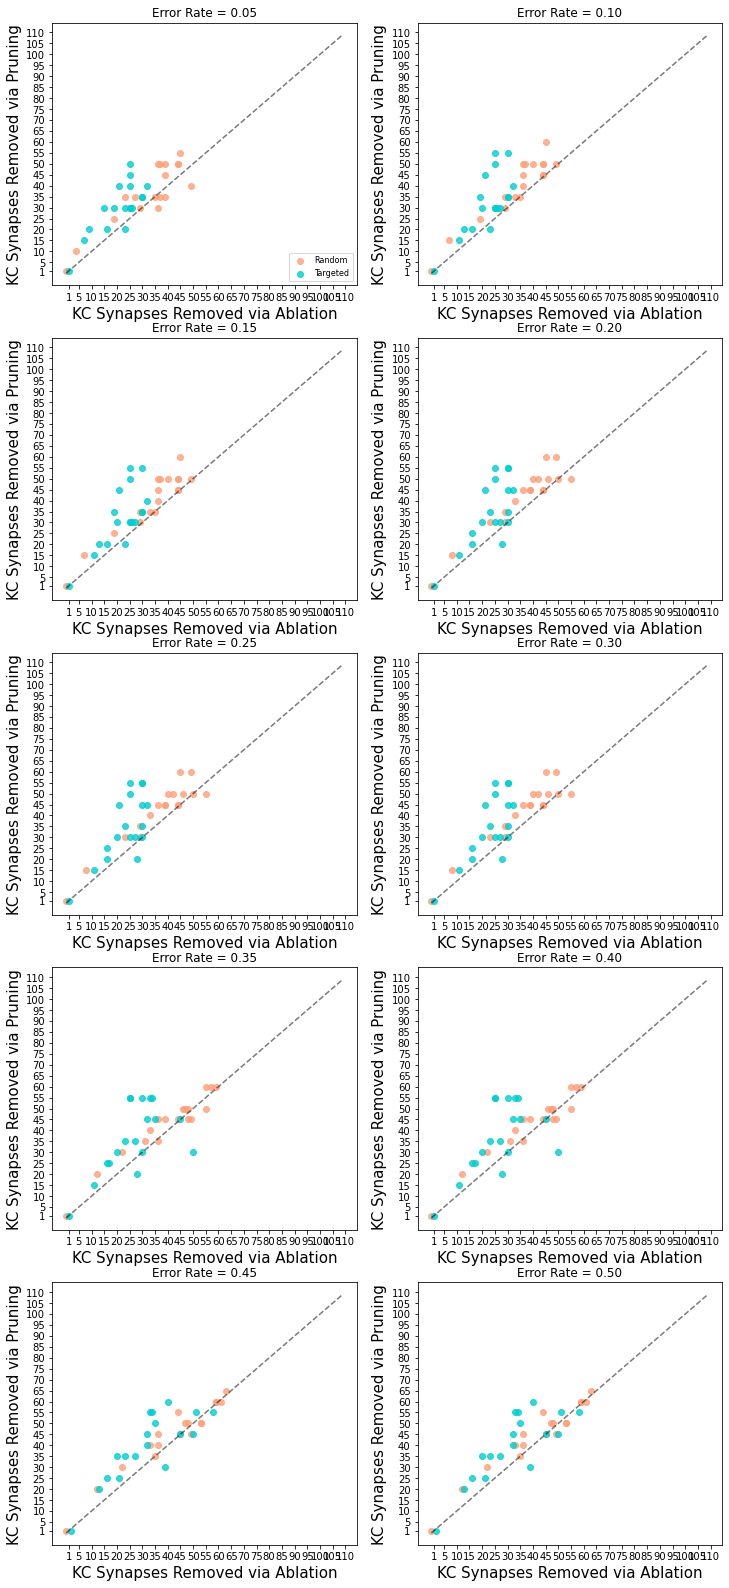

In [20]:
axis_fontsize = 15
title_fontsize = 20
legend_fontsize = 8
num_mbons = 18 # exclude fict MBON

# RANDOM
# import data 
with open('C:/Katherine/Research/experiment-data-v3/10-odors-left/control2/all-error-rates7.pkl', 'rb') as f:
    error_control_p = pickle.load(f) # dimensions: R, T, num_mbons
error_control_a = error_control_p
with open('C:/Katherine/Research/experiment-data-v3/10-odors-left/random-pruning/all-error-rates12.pkl', 'rb') as f:
    error_over_time_p = pickle.load(f) # dimensions: K, R, T, num_mbons
    
with open('C:/Katherine/Research/experiment-data-v3/10-odors-left/random-ablation/all-error-rates14.pkl', 'rb') as f:
    error_over_time_a = pickle.load(f) # dimensions: K, R, T, num_mbons
    
with open('C:/Katherine/Research/experiment-data-v3/10-odors-left/random-ablation/kcs-removed14.pkl', 'rb') as f:
    kcs_removed = pickle.load(f)

# number of KCs supposedly to be removed
numbers = np.ones(23)
numbers[1:] = np.linspace(5, 110, 22)
numbers = numbers.astype(int).tolist()

E = 10 # number of error rate thresholds
rates = np.linspace(0.05, 0.5, num=10) # error rates from 0 to 0.5

# PRUNING
# x_p - number of KC synapses removed 
x_p = []

for i in range(num_mbons):
    for j in range(K):
        x_p.append(numbers[j])

# y_p - final error rate for realization r
y_p = []
for k in range(num_mbons):
    for i in range(K):
        y_p.append(error_over_time_p[i,0,-1,k]) # exclude fictional MBON (will skew results)

# ABLATION
# gets number of presynaptic KCs for each MBON
bool_synapses = np.where(kc_mbon > 0, 1, 0)
conn = np.zeros(num_mbons)
for j in range(num_mbons):
    conn[j] = bool_synapses[:,j].sum()
conn = conn.astype(int) # number of connections to each MBON

# number of KCs removed
x_a = []

# x_a - calculates the actual number of synapses removed after ablation
for i in range(num_mbons):
    for j in range(K):
        n = numbers[j] # num kcs ablated
        l = kcs_removed[j][0] # list of kcs removed for realization 1
        l_num = get_num_kc(l, n) # converts list of names to numbers

        num_removed = count_num_removed(kc_mbon, l_num, i) # number of kc connections removed from this MBON
        x_a.append(num_removed)    

# y_a - final error rate for realization r
y_a = []
for m in range(num_mbons):
    for k in range(K):
        y_a.append(error_over_time_a[k, 0, -1, m]) # excludes fict. MBON (skews results)

# SUMMARY (ER = 0.3)
# pruning
x_p = np.asarray(x_p).reshape(num_mbons, K)
y_p = np.asarray(y_p).reshape(num_mbons, K)

# ablation
x_a = np.asarray(x_a).reshape(num_mbons, K)
y_a = np.asarray(y_a).reshape(num_mbons, K)


# PLOT
fig, ax = plt.subplots(5, 2, figsize=(12, 28))

# MBON names
names = kc_mbon.columns[0:-1]

# loop through error rates
x_total_r = np.zeros((E, num_mbons))
y_total_r = np.zeros((E, num_mbons))
for e in range(E):
    
    # Get the x and y coordinates for summary plot
    x = np.zeros(num_mbons) # ablation
    y = np.zeros(num_mbons) # pruning

    for m in range(num_mbons):
        num_removed_x = 0
        # ablation
        found_a = False
        k_a = 0 # move through the columns
        while (not found_a) and (k_a < K):
            if y_a[m, k_a] >= rates[e]:
                x[m] = x_a[m, k_a]
                found_a = True
            k_a += 1

        # pruning
        found_p = False
        k_p = 0 # move through the columns
        while (not found_p) and (k_p < K):
            # ablation
            if y_p[m, k_p] >= rates[e]:
                y[m] = x_p[m, k_p]
                found_p = True
            k_p += 1 
    
    x_total_r[e] = x
    y_total_r[e] = y

z = 0
for i in range(5):
    for j in range(2):
        ax[i, j].scatter(x_total_r[z], y_total_r[z], alpha=0.8, c=colors[13], label="Random")
        ax[i, j].plot(np.arange(110), np.arange(110), alpha=0.3, linestyle='dashed', color='black') # plot line y = x
        ax[i, j].set_xlabel("KC Synapses Removed via Ablation", fontsize=axis_fontsize)
        ax[i, j].set_ylabel("KC Synapses Removed via Pruning", fontsize=axis_fontsize)
        ax[i, j].set_xticks(numbers)
        ax[i, j].set_yticks(numbers)
        ax[i, j].set_title(f"Error Rate = {rates[z]:.2f}", fontsize=12)
        z += 1
        
# TARGETED
# import data 
with open('C:/Katherine/Research/experiment-data-v3/10-odors-left/control2/all-error-rates7.pkl', 'rb') as f:
    error_control_p = pickle.load(f) # dimensions: R, T, num_mbons
error_control_a = error_control_p
with open('C:/Katherine/Research/experiment-data-v3/10-odors-left/targeted-pruning/all-error-rates13.pkl', 'rb') as f:
    error_over_time_p = pickle.load(f) # dimensions: K, R, T, num_mbons
    
with open('C:/Katherine/Research/experiment-data-v3/10-odors-left/targeted-ablation/all-error-rates10.pkl', 'rb') as f:
    error_over_time_a = pickle.load(f) # dimensions: K, R, T, num_mbons
    
with open('C:/Katherine/Research/experiment-data-v3/10-odors-left/targeted-ablation/kcs-removed10.pkl', 'rb') as f:
    kcs_removed = pickle.load(f)

# PRUNING
# x_p - number of KC synapses removed 
x_p = []

for i in range(num_mbons):
    for j in range(K):
        x_p.append(numbers[j])

# y_p - final error rate for realization r
y_p = []
for k in range(num_mbons):
    for i in range(K):
        y_p.append(error_over_time_p[i,0,-1,k]) # exclude fictional MBON (will skew results)

# ABLATION
# gets number of presynaptic KCs for each MBON
bool_synapses = np.where(kc_mbon > 0, 1, 0)
conn = np.zeros(num_mbons)
for j in range(num_mbons):
    conn[j] = bool_synapses[:,j].sum()
conn = conn.astype(int) # number of connections to each MBON

# number of KCs removed
x_a = []

# x_a - calculates the actual number of synapses removed after ablation
for i in range(num_mbons):
    for j in range(K):
        n = numbers[j] # num kcs ablated
        l = kcs_removed[j][0] # list of kcs removed for realization 1
        l_num = get_num_kc(l, n) # converts list of names to numbers

        num_removed = count_num_removed(kc_mbon, l_num, i) # number of kc connections removed from this MBON
        x_a.append(num_removed)    

# y_a - final error rate for realization r
y_a = []
for m in range(num_mbons):
    for k in range(K):
        y_a.append(error_over_time_a[k, 0, -1, m]) # excludes fict. MBON (skews results)

# SUMMARY (ER = 0.3)
# pruning
x_p = np.asarray(x_p).reshape(num_mbons, K)
y_p = np.asarray(y_p).reshape(num_mbons, K)

# ablation
x_a = np.asarray(x_a).reshape(num_mbons, K)
y_a = np.asarray(y_a).reshape(num_mbons, K)


# PLOT

# loop through error rates
x_total_t = np.zeros((E, num_mbons))
y_total_t = np.zeros((E, num_mbons))
for e in range(E):
    
    # Get the x and y coordinates for summary plot
    x = np.zeros(num_mbons) # ablation
    y = np.zeros(num_mbons) # pruning

    for m in range(num_mbons):
        num_removed_x = 0
        # ablation
        found_a = False
        k_a = 0 # move through the columns
        while (not found_a) and (k_a < K):
            if y_a[m, k_a] >= rates[e]:
                x[m] = x_a[m, k_a]
                found_a = True
            k_a += 1

        # pruning
        found_p = False
        k_p = 0 # move through the columns
        while (not found_p) and (k_p < K):
            # ablation
            if y_p[m, k_p] >= rates[e]:
                y[m] = x_p[m, k_p]
                found_p = True
            k_p += 1 
    
    x_total_t[e] = x
    y_total_t[e] = y

z = 0
for i in range(5):
    for j in range(2):
        ax[i, j].scatter(x_total_t[z], y_total_t[z], alpha=0.8, c=colors[8], label="Targeted")
        ax[i, j].plot(np.arange(110), np.arange(110), alpha=0.3, linestyle='dashed', color='black') # plot line y = x
        ax[i, j].set_xlabel("KC Synapses Removed via Ablation", fontsize=axis_fontsize)
        ax[i, j].set_ylabel("KC Synapses Removed via Pruning", fontsize=axis_fontsize)
        ax[i, j].set_xticks(numbers)
        ax[i, j].set_yticks(numbers)
        ax[i, j].set_title(f"Error Rate = {rates[z]:.2f}", fontsize=12)
        z += 1

ax[0, 0].legend(fontsize=legend_fontsize, loc=4)
plt.show()

In [21]:
print(y_total_t) # pruning
print(x_total_t) # ablation

[[20. 40. 20. 40. 50. 35. 30. 30. 30. 45. 35. 40. 30. 20. 30.  1. 15. 30.]
 [20. 40. 20. 45. 55. 35. 30. 35. 30. 50. 35. 55. 30. 20. 30.  1. 15. 30.]
 [20. 40. 20. 45. 55. 35. 30. 35. 30. 50. 35. 55. 30. 20. 30.  1. 15. 30.]
 [20. 45. 20. 45. 55. 45. 50. 35. 30. 55. 35. 55. 30. 25. 30.  1. 15. 30.]
 [20. 45. 20. 45. 55. 45. 50. 35. 30. 55. 35. 55. 30. 25. 30.  1. 15. 30.]
 [20. 45. 20. 45. 55. 45. 50. 35. 30. 55. 35. 55. 30. 25. 30.  1. 15. 30.]
 [25. 45. 20. 45. 55. 55. 55. 35. 30. 55. 45. 55. 30. 25. 30.  1. 15. 35.]
 [25. 45. 20. 45. 55. 55. 55. 35. 30. 55. 45. 55. 30. 25. 30.  1. 15. 35.]
 [25. 45. 40. 45. 55. 55. 60. 35. 30. 55. 50. 55. 35. 25. 45.  1. 20. 35.]
 [25. 45. 40. 45. 55. 55. 60. 35. 30. 55. 50. 55. 35. 25. 45.  1. 20. 35.]]
[[16. 32. 23. 21. 25. 30. 25. 19. 25. 25. 30. 25. 15.  9. 26.  1.  7. 23.]
 [16. 32. 23. 21. 25. 30. 25. 19. 25. 25. 30. 30. 20. 13. 26.  1. 11. 27.]
 [16. 32. 23. 21. 25. 30. 25. 19. 25. 25. 30. 30. 20. 13. 26.  1. 11. 27.]
 [16. 32. 28. 21. 30. 30

In [22]:
def calculate_reg_slope(x, y):
    all_slopes = np.zeros(E)

    for e in range(E):
        sum1 = 0
        sum2 = 0
        for m in range(num_mbons):
            sum1 += x[e, m] * y[e, m]
            sum2 += x[e, m] ** 2
        all_slopes[e] = sum1 / sum2

    return all_slopes

In [23]:
# calculating slope of the regression 
# equation based on regression-formula equation ss
all_slopes_t = calculate_reg_slope(x_total_t, y_total_t)
    
print(all_slopes_t)

[1.39067825 1.42939336 1.42939336 1.46766215 1.46766215 1.46766215
 1.27987877 1.27987877 1.18354343 1.18354343]


In [24]:
# calculating slope of the regression 
all_slopes_r = calculate_reg_slope(x_total_r, y_total_r)
    
print(all_slopes_r)

[1.10953773 1.15499509 1.15499509 1.12553231 1.12553231 1.12553231
 1.04579641 1.04579641 1.0371057  1.0371057 ]


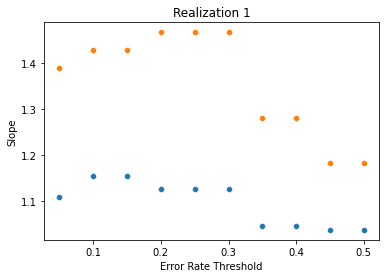

In [25]:
# plot figure
plot_data_r = pd.DataFrame({'ER':rates, 'Slope':all_slopes_r})
plot_data_t = pd.DataFrame({'ER':rates, 'Slope':all_slopes_t})

plt.figure()
sns.scatterplot(data=plot_data_r, x="ER", y="Slope")
sns.scatterplot(data=plot_data_t, x="ER", y="Slope")
# plt.errorbar(x=plot_data['ER'], y=plot_data['Slope'], yerr=plot_data['SEM'], fmt="o", ls='solid', alpha = 0.8)
plt.xlabel("Error Rate Threshold")
plt.ylabel("Slope")
plt.title("Realization 1")
plt.show()

[0, 3, 7, 12, 16, 19, 21, 25, 30, 35, 40, 44, 48, 52, 54, 55, 55, 55, 55, 55, 55, 55, 55, 1, 4, 9, 14, 19, 24, 28, 32, 37, 42, 47, 52, 56, 61, 62, 63, 63, 63, 63, 63, 63, 63, 63, 1, 5, 10, 14, 19, 23, 28, 32, 37, 42, 43, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 1, 5, 10, 14, 18, 21, 26, 30, 35, 39, 41, 45, 46, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 1, 5, 10, 15, 20, 25, 30, 34, 39, 43, 48, 53, 53, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 1, 5, 10, 15, 20, 25, 30, 33, 37, 42, 46, 50, 51, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 58, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 1, 4, 9, 14, 18, 19, 23, 26, 27, 32, 36, 37, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 1, 5, 10, 15, 20, 25, 30, 34, 39, 44, 49, 54, 58, 60, 61, 61, 61, 61, 61, 61, 61, 61, 61, 1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 54, 58, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 1, 5, 10, 15, 20, 25, 30, 35, 40, 44, 48, 50, 52, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 1, 5, 10, 15

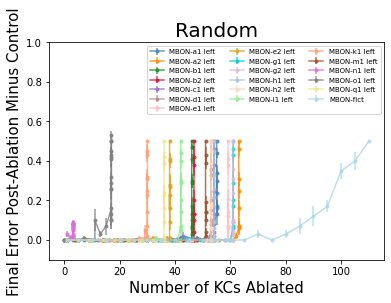

In [10]:
# 4G ERROR VS NUM KCS ABLATED - RANDOM
plt.figure()

num_mbons = 19
K = 23
T = 5000

# import data
with open('C:/Katherine/Research/experiment-data-v3/10-odors/random-ablation/all-error-rates14.pkl', 'rb') as f:
    error_over_time = pickle.load(f) # dimensions: K, R, T, num_mbons
    
with open('C:/Katherine/Research/experiment-data-v3/10-odors/control2/all-error-rates7.pkl', 'rb') as f:
    error_control = pickle.load(f) # dimensions: R, T, num_mbons

# x-axis -> number of KCs removed
numbers = np.ones(23)
numbers[1:] = np.linspace(5, 110, 22)
numbers = numbers.astype(int).tolist() 

# x - calculates the actual number of synapses removed after ablation
x = []       
        
# gets number of presynaptic KCs for each MBON
bool_synapses = np.where(kc_mbon > 0, 1, 0)
conn = np.zeros(num_mbons)
for j in range(num_mbons):
    conn[j] = bool_synapses[:,j].sum()
conn = conn.astype(int) # number of connections to each MBON

for i in range(num_mbons):
    for j in range(K):
        n = numbers[j] # num kcs ablated
        l = kcs_removed[j][0] # list of kcs removed for realization 1
        l_num = get_num_kc(l, n) # converts list of names to numbers

        num_removed = count_num_removed(kc_mbon, l_num, i) # number of kc connections removed from this MBON
        x.append(num_removed)  
print(x)

# y-axis - avg final error rate
avg_error0 = np.mean(error_control, axis=0)
avg_error = np.zeros((K, T, num_mbons))
for i in range(K):
    avg_error[i] = np.mean(error_over_time[i], axis=0)

std_y = np.zeros((K, T, num_mbons))
for i in range(K):
#     std_y[i] = np.std(error_over_time[i], axis=0)
    std_y[i] = st.sem(error_over_time[i], axis=0)

yerr = []
for k in range(num_mbons):
    for i in range(K):
        yerr.append(std_y[i,-1,k])
    
y = []
# add differences in ablation error rate and control
for k in range(num_mbons):
    for i in range(K):
        y.append(avg_error[i,-1,k] - avg_error0[-1,k])

# plot points with lines and labels
names = kc_mbon.columns
for p in range(num_mbons):
    start = p * K
    end = (p * K) + K
    plt.errorbar(x[start:end], y[start:end], yerr=yerr[start:end], fmt="o", ls='solid', alpha = 0.8, 
                    label=kc_mbon.columns[p], ms=3, c=colors[p])

plt.xlabel("Number of KCs Ablated", fontsize=axis_fontsize)
plt.ylabel("Final Error Post-Ablation Minus Control", fontsize=axis_fontsize)
plt.ylim(-0.1, 1.0)
plt.title("Random", fontsize=title_fontsize)
plt.legend(fontsize=7, loc=1, ncol=3)